In [46]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
data = pd.read_csv('stock.csv')

In [48]:
features = ['Open', 'High', 'Low']

X = data.loc[:, features]

Y = data[['Close']]

In [49]:
# MinMax scaler

X_max = X.max()
Y_max = Y.max()

X_min = X.min()
Y_min = Y.min()

X_s = (X - X_min) / (X_max - X_min)
Y_s = (Y - Y_min) / (Y_max - Y_min)

In [50]:
window_size = 30

def make_dataset(x_data, y_data, window_size):
    x_list = []
    y_list = []
    
    for i in range(len(x_data) - window_size):
        x_list.append(np.array(x_data.iloc[i:i + window_size]))
        y_list.append(np.array(y_data.iloc[i + window_size]))
    
    x_list = torch.Tensor(np.array(x_list))
    y_list = torch.Tensor(np.array(y_list))
    
    return torch.Tensor(x_list), torch.Tensor(y_list).squeeze(-1)

X_w, Y_w = make_dataset(X_s, Y_s, window_size)

In [51]:
train_num = 700
X_train = X_w[:train_num].to(device)
X_test = X_w[train_num:].to(device)

y_train = Y_w[:train_num].to(device)
y_test = Y_w[train_num:].to(device)

In [52]:
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size = 32)

for x_data, y_data in train_loader:
    break

print(x_data.shape)
print(y_data.shape)

torch.Size([32, 30, 3])
torch.Size([32])


In [53]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size = len(features), hidden_size = 8, num_layers = 5, batch_first = True)
        self.fc1 = nn.Linear(in_features = window_size * 8, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(5, x.shape[0], 8).to(device)
        x, hn = self.rnn(x, h0)

        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.squeeze(-1)
        
        return x

In [54]:
# 난수 고정
torch.cuda.manual_seed(123)

input_size = len(features)
hidden_size = 8
num_layers = 5
model = RNN()
model.to(device)
lr = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history_train=[]
loss_history_test=[]

In [55]:
num_epochs = 2000
for epoch in range(num_epochs):
    
    for x_data, y_data in train_loader:
        optimizer.zero_grad()
        
        outputs = model(x_data)
        loss_train = nn.MSELoss()(outputs, y_data)

        loss_train.backward()
        optimizer.step()

    outputs_train = model(X_train)
    loss_train = nn.MSELoss()(outputs_train, y_train)

    outputs_test = model(X_test)
    loss_test = nn.MSELoss()(outputs_test, y_test)

    loss_history_train.append(loss_train.item())
    loss_history_test.append(loss_test.item())
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss_train: .5f}, loss_test: {loss_test:.5f}')

Epoch [1/2000], loss:  0.12157, loss_test: 0.35868
Epoch [101/2000], loss:  0.00222, loss_test: 0.00675
Epoch [201/2000], loss:  0.00178, loss_test: 0.00543
Epoch [301/2000], loss:  0.00139, loss_test: 0.00414
Epoch [401/2000], loss:  0.00118, loss_test: 0.00338
Epoch [501/2000], loss:  0.00109, loss_test: 0.00312
Epoch [601/2000], loss:  0.00102, loss_test: 0.00291
Epoch [701/2000], loss:  0.00097, loss_test: 0.00273
Epoch [801/2000], loss:  0.00088, loss_test: 0.00249
Epoch [901/2000], loss:  0.00085, loss_test: 0.00229
Epoch [1001/2000], loss:  0.00081, loss_test: 0.00210
Epoch [1101/2000], loss:  0.00078, loss_test: 0.00194
Epoch [1201/2000], loss:  0.00074, loss_test: 0.00180
Epoch [1301/2000], loss:  0.00072, loss_test: 0.00168
Epoch [1401/2000], loss:  0.00070, loss_test: 0.00158
Epoch [1501/2000], loss:  0.00069, loss_test: 0.00150
Epoch [1601/2000], loss:  0.00067, loss_test: 0.00142
Epoch [1701/2000], loss:  0.00065, loss_test: 0.00136
Epoch [1801/2000], loss:  0.00064, loss_

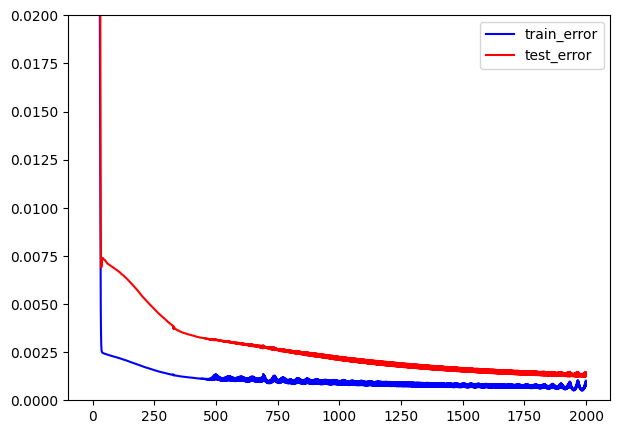

In [57]:
plt.figure(figsize = (7,5))
plt.plot(loss_history_train, 'b', label = 'train_error')
plt.plot(loss_history_test, 'r', label = 'test_error')
plt.ylim([0, 0.02])
plt.legend()
plt.show()

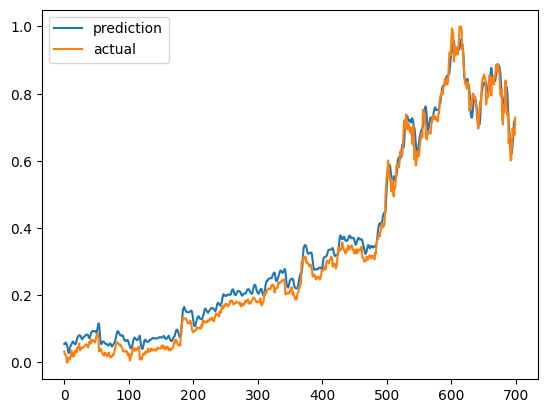

In [59]:
plt.plot(outputs_train.to('cpu').detach(), label='prediction')
plt.plot(y_train.to('cpu'), label = 'actual')
plt.legend()
plt.show()

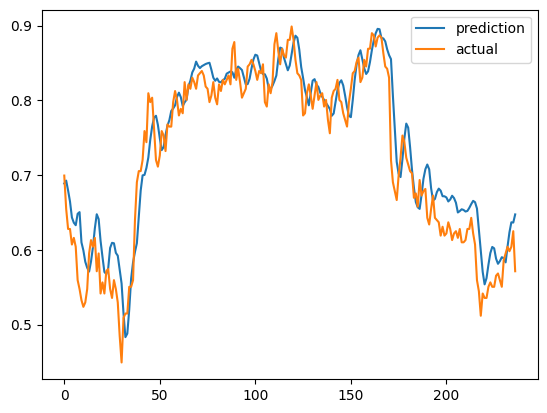

In [60]:
plt.plot(outputs_test.to('cpu').detach(), label = 'prediction')
plt.plot(y_test.to('cpu'), label = 'actual')
plt.legend()
plt.show()

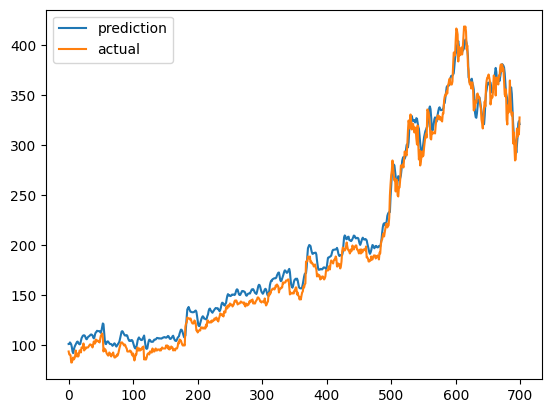

In [61]:
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * outputs_train.to('cpu').detach() + torch.Tensor([Y_min.item()]), label = 'prediction')
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * y_train.to('cpu') + torch.Tensor([Y_min.item()]), label = 'actual')
plt.legend()
plt.show()
         